Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-28..1099].


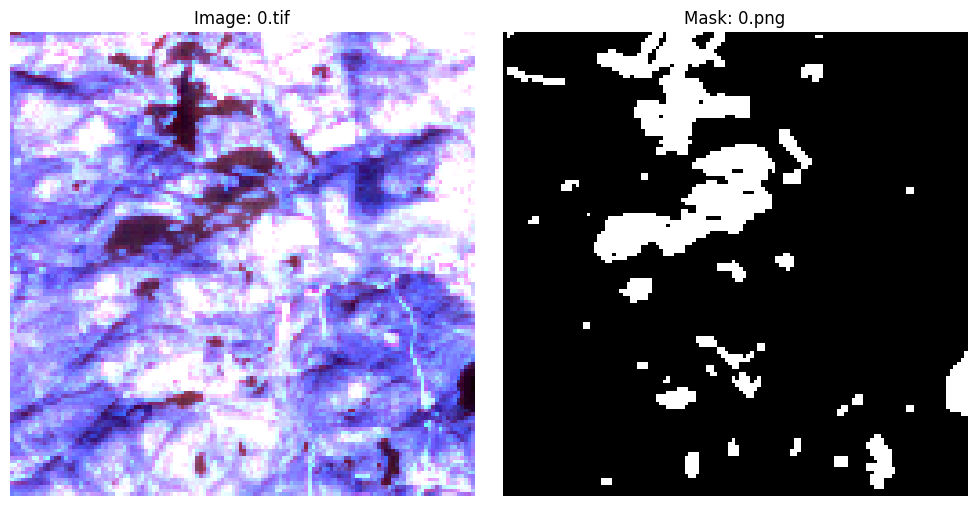

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [23..1165].


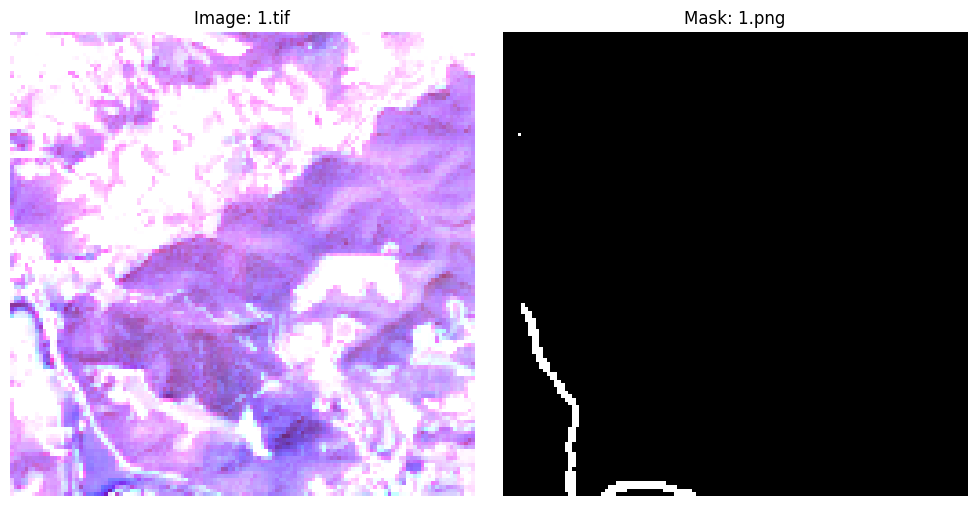

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103..1109].


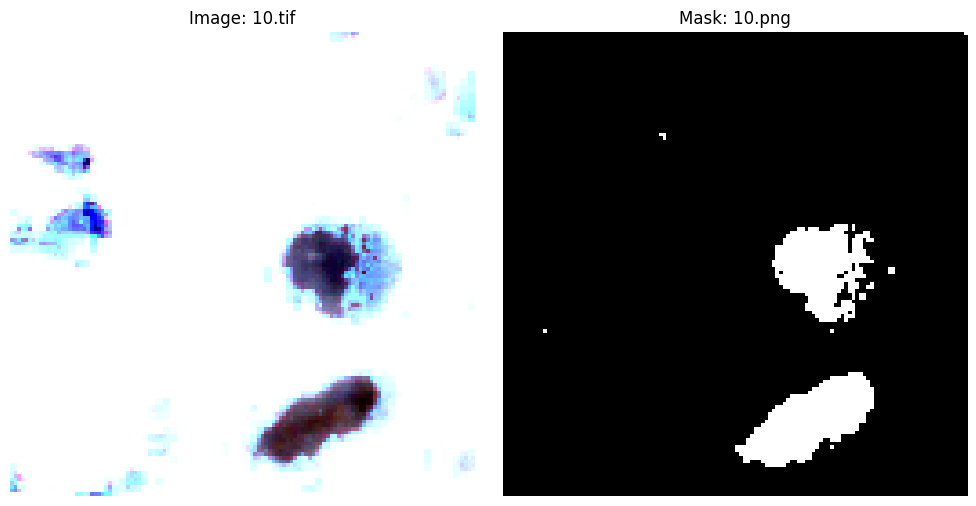

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-216..2456].


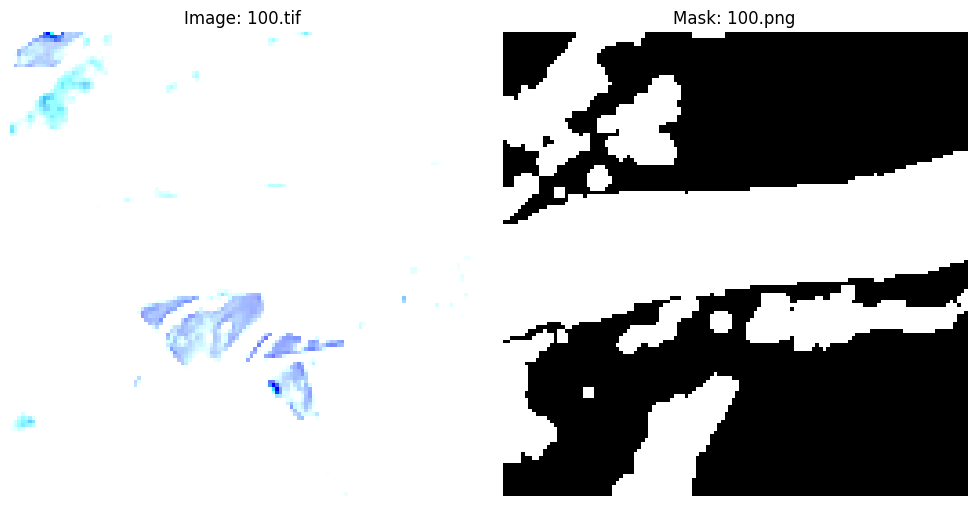

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [67..1802].


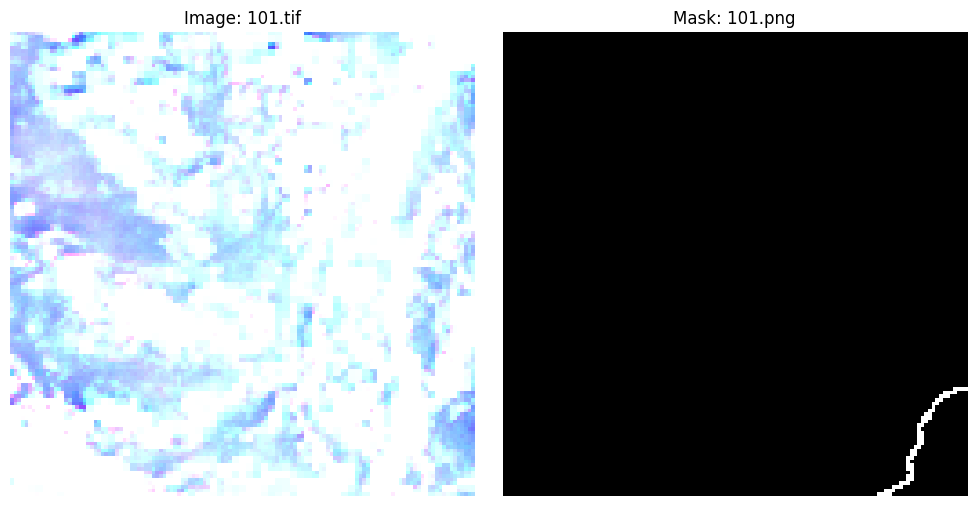

In [15]:
import os
import tifffile
from PIL import Image
import matplotlib.pyplot as plt

# Paths
image_folder = os.path.join('data', 'images')
label_folder = os.path.join('data', 'labels')

# Get sorted list of image and label files
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])

# Visualize first few examples
num_examples = min(5, len(image_files), len(label_files))

for i in range(num_examples):
    img_path = os.path.join(image_folder, image_files[i])
    mask_path = os.path.join(label_folder, label_files[i])
    
    image = tifffile.imread(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Handle multi-channel image
    if image.ndim == 3:
        if image.shape[2] >= 3:
            ax[0].imshow(image[..., :3])  # Show RGB
        else:
            ax[0].imshow(image[..., 0], cmap='gray')  # Show 1st channel
    else:
        ax[0].imshow(image, cmap='gray')

    ax[0].set_title(f'Image: {image_files[i]}')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f'Mask: {label_files[i]}')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# ==== Dataset ====

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
        self.labels = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.label_dir, self.labels[idx])

        image = tifffile.imread(img_path)
        if image.ndim == 2:
            image = image[np.newaxis, ...]  # 1xHxW
        else:
            image = np.transpose(image, (2, 0, 1))  # CxHxW

        image = image.astype(np.float32)
        image = (image - image.mean()) / (image.std() + 1e-8)

        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask, dtype=np.float32)
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0)  # 1xHxW

        return torch.tensor(image), torch.tensor(mask)

# ==== U-Net Model ====

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.double_conv(feature*2, feature))

        self.bottleneck = self.double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.functional.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final_conv(x))

# ==== Metrics ====

def compute_metrics(preds, targets):
    preds = (preds > 0.5).float().cpu().numpy().astype(np.uint8).ravel()
    targets = targets.cpu().numpy().astype(np.uint8).ravel()
    f1 = f1_score(targets, preds, zero_division=1)
    acc = accuracy_score(targets, preds)
    return f1, acc

# ==== Training ====

def train_fn(loader, model, loss_fn, optimizer, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch_idx, (data, targets) in enumerate(loader):
        data, targets = data.to(device), targets.to(device)

        preds = model(data)
        loss = loss_fn(preds, targets)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_preds.append(preds.detach())
        all_targets.append(targets.detach())

    # Compute metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    f1, acc = compute_metrics(all_preds, all_targets)

    return total_loss / len(loader), f1, acc

# ==== Main ====

def main():
    # Config
    image_dir = os.path.join('data', 'images')
    label_dir = os.path.join('data', 'labels')
    lr = 1e-3
    batch_size = 2
    epochs = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Dataset and loader
    dataset = SegmentationDataset(image_dir, label_dir)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Get input channels
    sample_img = tifffile.imread(os.path.join(image_dir, os.listdir(image_dir)[0]))
    in_channels = sample_img.shape[2] if sample_img.ndim == 3 else 1

    model = UNet(in_channels=in_channels).to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training logs
    logs = []

    for epoch in range(epochs):
        loss, f1, acc = train_fn(loader, model, loss_fn, optimizer, device)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}")
        logs.append({'epoch': epoch+1, 'loss': loss, 'f1_score': f1, 'accuracy': acc})

    # Save logs
    log_df = pd.DataFrame(logs)
    log_df.to_csv("training_log.csv", index=False)

    # Save model
    torch.save(model.state_dict(), "unet_model.pth")
    print("Training complete. Model and logs saved.")

if __name__ == "__main__":
    main()


Epoch 1/10 | Loss: 0.1177 | F1: 0.0000 | Accuracy: 0.9867
Epoch 2/10 | Loss: 0.1019 | F1: 1.0000 | Accuracy: 1.0000
